C:\Users\siink\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


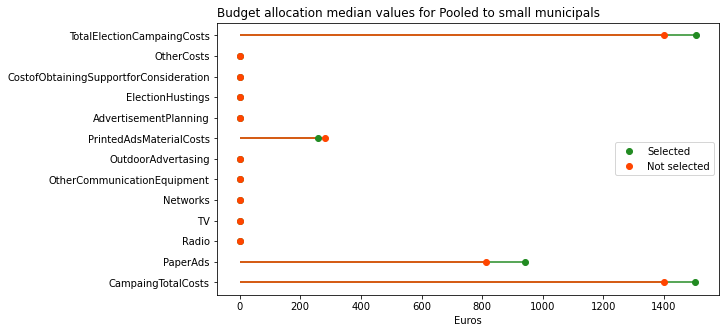

NameError: name 'y_name' is not defined

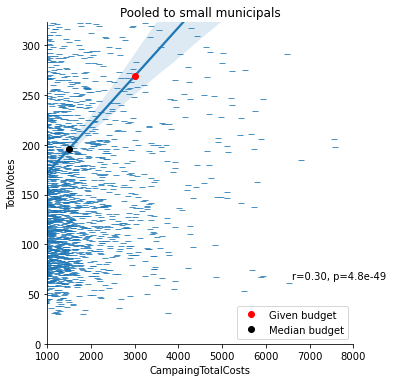

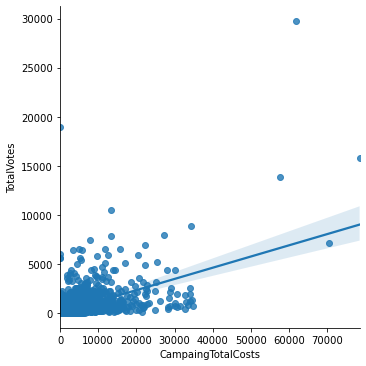

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier


#FUNCTIONS:

def rename_to_english(df):
    ''' rename the column names in english '''
    #    df.columns 'Unnamed: 0', 'Kuntanro','Puolue', 'Vaalikampanjan kulut yhteensa', 'Sanoma- ilmaisjakelu- ja aikakauslehdet',
    #'Radio', 'Televisio', 'Tietoverkot', 'Muut viestintavalineet', 'Ulkomainonta', 'Vaalilehtien esitteiden ja muun painetun materiaalin hankinta',
    #'Mainonnan suunnittelu',  'Vaalitilaisuudet','Vastikeellisen tuen hankintakulut','Muut kulut','Vaalikampanjan rahoitus yhteensa', 
    #'Sukupuoli',  'Ikä vaalipäivänä', 'Ennakkoäänet lkm','Vaalipäivän äänet lkm', 'Äänet yhteensä lkm','Osuus äänistä yht. (%)', 
    #'Valintatieto',  'Name', 'Population'
    eng_col_names =[ 'Unnamed: 0', 'MunicipalNum', 'Party', 'CampaingTotalCosts', 'PaperAds','Radio',
                    'TV', 'Networks', 'OtherCommunicationEquipment', 'OutdoorAdvertasing', 'PrintedAdsMaterialCosts','AdvertisementPlanning', 
                    'ElectionHustings', 'CostofObtainingSupportforConsideration', 'OtherCosts', 'TotalElectionCampaingCosts', 'Gender', 
                    'Age', 'PreVotes','ElectionDayVotes','TotalVotes','RelativeVotes(%)', 'Selected', 'MunicipalName','Population']
    df.columns = eng_col_names
    return df

def budget_distribution(df, municipal, plot=True,  flag_median = True):
    ''' This function returns median adverisement cost for chosen. 
    Optional: plots the lollipop plot of chosen and not chosen candidates from the municipal.
    INPUT:
        df = dataFrame consisting poll data
        municipal = string of the municipal chosen will be used in plot title
        plot = default True,  plots the lollilpop chart 
        flag_median = default True, computes median values, if set False computes mean  

    OUTPUT:
        X_chosen = vector of the median values for among chosen candidates  
        x_vars =  names of the advertisemen candidates
    '''

    #Divide to chosen or not candidates:
    df_chosen = df[df['Selected']==1]
    df_not_chosen = df[df['Selected']==2]
    
    #Advertisement variables:
    x_vars = ['CampaingTotalCosts', 'PaperAds', 'Radio', 'TV', 'Networks', 'OtherCommunicationEquipment',
              'OutdoorAdvertasing', 'PrintedAdsMaterialCosts','AdvertisementPlanning', 'ElectionHustings',
              'CostofObtainingSupportforConsideration','OtherCosts','TotalElectionCampaingCosts']

    
    X_chosen = []
    X_not_chosen = []
    for var in x_vars:
        if flag_median:
            X_chosen.append(df_chosen[var].median())
            X_not_chosen.append(df_not_chosen[var].median())
        else:
            X_chosen.append(df_chosen[var].mean())
            X_not_chosen.append(df_not_chosen[var].mean())

    if plot:
        # The horizontal plot is made using the hline function:
        plt.figure(figsize=(9,5))
        plt.hlines(y=range(len(X_not_chosen)), xmin=0, xmax=X_chosen, color='forestgreen')
        plt.plot(X_chosen, range(len(X_not_chosen)), "o", color='forestgreen')

        plt.hlines(y=range(len(X_not_chosen)), xmin=0, xmax=X_not_chosen, color='orangered')
        plt.plot(X_not_chosen, range(len(X_not_chosen)), "o", color='orangered')

        # Add titles and axis names
        plt.yticks(range(len(X_not_chosen)), x_vars)
        plt.title(f"Budget allocation median values for {municipal}", loc='left')
        plt.xlabel('Euros')
        plt.legend(['Selected', 'Not selected'], loc='right')

        # Show the plot
        #plt.savefig('temp.png', dpi=400)
        plt.show()
        
    return X_chosen, x_vars


def pool_df(df, municipal,  min_number_candicates = 100, budget_at_least=1000, min_number_TotalVotes = 30):
    '''This function limits dataframe to municipal if "min_number_cancicates" of candicates with
    budget of "budget_at_least" and at least  "min_number_TotalVotes".
    
    OUTPUT:
        df_restric = Pooled/restricted dataframe
        municipal = name is changed to 'Pooled to small municipals' of there is not enough cancidates
    '''
    
    # limit dataframe:
    df_restric = df[(df['TotalElectionCampaingCosts'] >=budget_at_least)  &  (df['TotalVotes'] >=min_number_TotalVotes)]

    #Check first the municipal size:
    df_part = df[['MunicipalName', 'Population']]
    mean_population = df_part.groupby(['MunicipalName']).mean()

    df_part1 = df_restric[['MunicipalName']]
    voter_num_municipal = df_part1.value_counts()
    voter_num_municipal = voter_num_municipal[voter_num_municipal >= min_number_candicates] 
    #import pdb; pdb.set_trace() #ok
    
    #Categorization:
    if municipal in voter_num_municipal: #belongs to big city

        df_restric = df_restric[df_restric['MunicipalName'] == municipal]

    else: #Belongs to small municipal --> this is grouped to one:
        
        municipal = 'Pooled to small municipals'
        biggest_cities_lst = voter_num_municipal.index.tolist() #this is tuple for some reason?
        biggest_cities_lst_corr = []
        for b in biggest_cities_lst:
            biggest_cities_lst_corr.append(b[0])

        df_restric = df_restric[~df_restric.MunicipalName.isin(biggest_cities_lst_corr)] #restrict data
    
    return df_restric, municipal

        
def budget_allocation(df, municipal, plot=True, min_number_candicates = 100, budget_at_least = 1000):
    '''Main Function which computes result of how others have spend their money '''
    df_restric,municipal =  pool_df(df, municipal, min_number_candicates, budget_at_least)
    X_chosen, x_vars = budget_distribution(df_restric, municipal, plot=plot, flag_median = True)
    return X_chosen, x_vars, df_restric, municipal



def annotate(data,name_var1,name_var2, **kws):
    '''Plot helper function showing correlation and p-value'''    
    r, p = sp.stats.pearsonr(data[name_var1], data[name_var2])
    ax = plt.gca()
    ax.text(.8, .2, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    sns.lmplot(x=name_var1,y=name_var2,data=df,fit_reg=True)


def print_scatterplot(df, x_name, y_name, X_pred, y_pred, municipal):
    ''' scatterplor showing regression line between total budged (x_name) and num votes (y_name)
    INPUT
         df = dataFrame consisting x_name and y_name columns
         x_name =  x-axis variable   
         y_name = y-axis predicted variable
         X_pred, y_pred = points higlighting the given budget red and median budget 
         municipal = string of the municipal (if small city then all cmall cities pooled together)
    OUTPUT: None
    '''
    
    df[y_name].astype(float)
    df[x_name].astype(float)
    
    sns.lmplot(x = x_name,y=y_name, markers=False, data=df,fit_reg=True) 
    plt.plot(X_pred[0], y_pred[0], 'ro', label="Given budget") 
    plt.plot(X_pred[1], y_pred[1], 'ko',  label='Median budget')
    plt.title(municipal)
    plt.legend()
    plt.xlim([1000, 5000+ np.max(X_pred)])
    plt.ylim([0, 1.2*np.max(y_pred)])
    annotate(df,x_name,y_name)
    
def comp_regression(df, municipal,budget, x_name = 'CampaingTotalCosts', y_name = 'TotalVotes', plot=True):
    ''' This function computes univariate regression for x_name and y_name on chosen municipal and computes voting estimate using
    budget value as input for model
    INPUT:
        df =Dataframe 
        municipal =string name
        budget = given budget 
        x_name = 'CampaingTotalCosts', y_name = 'TotalVotes', plot=True
    OUTPUT:
        y_pred = univariate prediction of votes based on budget in municipal
        y_pred_med  = univariate prediction of votes based on median budget on that municipal
    '''
    X_chosen, x_vars, df_restric, municipal  = budget_allocation(df, municipal, plot=False)

    df_restric = df_restric[df_restric['Selected']==1]   #take only chosen ones
    #Fit data:
    X = df_restric[x_name].values
    X = np.expand_dims(X, axis=1)
    y = df_restric[y_name].values
    
    #fit model:
    model = LinearRegression().fit(X, y)

    #predict using budget:
    X_pred = np.array([budget])
    X_pred = np.expand_dims(X_pred, axis=1)
    y_pred = model.predict(X_pred)

    #predict using median budget:
    X_pred_med = np.array([X_chosen[0]])
    X_pred_med = np.expand_dims(X_pred_med, axis=1)
    y_pred_med = model.predict(X_pred_med)

    #plot:
    if plot:
        print_scatterplot(df_restric, x_name, y_name, np.array([X_pred[0], X_pred_med[0]]),np.array([y_pred[0], y_pred_med[0]]),
                 municipal)        

    return y_pred, y_pred_med


def Majority_upsampling(df_restric, x_vars, yname = 'Selected'):
    '''This function corrects for the classification class imbalance between selected and not selected suing SMOTE

    OUTPUT:
        X =  np.array of X 
        y = np.array of predictable variable Selected or not
    '''
    
    # Separate majority and minority classes
    df_majority = df_restric[df_restric[yname] == 1]
    df_minority = df_restric[df_restric[yname] == 2]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    df_upsampled[yname].value_counts()

    #Observations:
    X = df_upsampled[x_vars].astype(float)
    X = X.to_numpy()

    #Predictable var:
    y = df_upsampled[yname].astype(float)
    y = y.to_numpy()
    
    return X, y



def multi_var_regression(df, municipal, budget):
    ''' Multi variate linear regression analysis
    OUTPUT:
        y_votes = estimated number of votes
        y_votes_med = estimated number of votes using median ad cost among chosen candidates
        regression score
    '''
    X_chosen, x_vars, df_restric,municipal  = budget_allocation(df, municipal,plot=False)
    df_restric = df_restric[df_restric['Selected']==1]   #take only chosen ones

    y_train = df_restric[y_name].values

    df_X = df_restric[x_vars]

    X_train = df_X.to_numpy()
    #X = StandardScaler().fit_transform(X)
    #train using all data!
    #    X_train, X_test, y_train, y_test = \
    #train_test_split(X, y, test_size=.1, random_state=42)

    reg = LinearRegression().fit(X_train, y_train)
    
    #Distribute budget chosen:
    X_budget = budget*(X_chosen/np.sum(X_chosen[1:-1]))

    X_budget[0] =budget
    X_budget[-1] =budget

    
    y_votes = reg.predict(np.expand_dims(X_budget, axis=0))
    y_votes_median = reg.predict(np.expand_dims(X_chosen, axis=0))
    return y_votes, y_votes_median, reg.score(X_train, y_train)




def classify_chosen_not(df, municipal, budget):
    '''This function classifies based on budget and municipal using simple decisision tree
    OUTPUT:
      y_budget = 1,2 --> 1 chosen 2 not chosen, using budget and allocation to median selected candidate
      y_chosen =  1,2 --> 1 chosen 2 not chosen, using median budget of municipal
      CM  = Confusion matrix training set
      score = Accuracy score on training set 
    '''
    X_chosen, x_vars, df_restric,municipal  = budget_allocation(df, municipal, plot=False)
    df_restric = df_restric[df_restric['Selected']<=2] # remove 3
    
    #Class imbalance --> majority upsampling to overcome:
    X_train, y_train = Majority_upsampling(df_restric, x_vars, yname = 'Selected')
    
    



    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.1, random_state=42)

    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_est =  clf.predict(X_test)
    y_est =np.expand_dims(y_est, axis=1)
    y_test2 =np.expand_dims(y_test, axis=1)
    
    CM = confusion_matrix (y_test, y_est)
    score = clf.score(X_test, y_test)

    

    #Distribute budget chosen:
    X_budget = budget*(X_chosen/np.sum(X_chosen[1:-1]))

    X_budget[0] =budget
    X_budget[-1] =budget
    #X_budget  #ok

    X_chosen=np.expand_dims(X_chosen, axis=0)
    y_budget =  clf.predict(np.expand_dims(X_budget, axis=0))
    y_chosen =  clf.predict(X_chosen)
 
    
    return  y_budget, y_chosen, CM, score



#----------------------
#    MAIN:
#----------------------
df = pd.read_csv('Data_12_17_21_cleaned.csv')
df.head()
df = rename_to_english(df)

#Input parameters:
municipal = 'Iisalmi'
budget =  3000

#Budget allocation:
X_chosen, x_vars, df_restric,municipal  = budget_allocation(df, municipal, plot=True)

#Univariate regression estimate how many votes:
y_pred, y_pred_med =  comp_regression(df, municipal,budget, x_name = 'CampaingTotalCosts', y_name = 'TotalVotes', plot=True)
#Multivatiate regression analysis:
y_votes, y_votes_median, score = multi_var_regression(df, municipal, budget)

print('UNIVARIATE:')
print('Total budget estimated votes:')
print(y_pred)
print('Total median budget amont chosen candidates bring votes:')
print(y_pred_med)

print('MULTIVARIATE:')
print('Total budget disctibuted as median user estimated votes:')
print(y_votes)
print('Total median budget among categories chosen candidates bring votes:')
print(y_votes_median)

#classification:
y_budget, y_chosen, CM, score = classify_chosen_not(df, municipal, budget)

print('Estimate chosen (1) or not (2)?')
print('Total selected budget as distributed as median user')
print(y_budget)
print('Total budget as  median user')
print(y_chosen)

print('CM:')
print(CM)
print('Score:')
print(score)

27364


C:\Users\siink\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


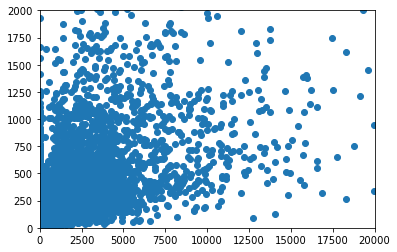

85.0


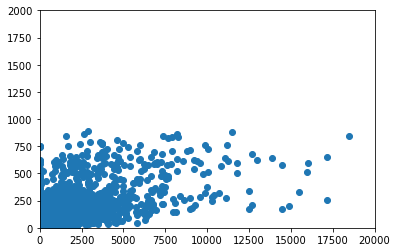

35.0
26017


In [14]:
df = pd.read_csv('Data_12_17_21_cleaned.csv')
df.head()
df = rename_to_english(df)

asd = df[df['Selected'] == 1]
#print(asd)
print(len(asd))

plt.scatter(asd['CampaingTotalCosts'], asd['TotalVotes'])
plt.xlim([0, 20000])
plt.ylim([0, 2000])
plt.show()

print(asd['TotalVotes'].median())

asd = df[df['Selected'] == 2]

plt.scatter(asd['CampaingTotalCosts'], asd['TotalVotes'])
plt.xlim([0, 20000])
plt.ylim([0, 2000])
plt.show()
print(asd['TotalVotes'].median())
#print(asd)
print(len(asd))



In [9]:
print(df.columns)

Index(['Unnamed: 0', 'MunicipalNum', 'Party', 'CampaingTotalCosts', 'PaperAds',
       'Radio', 'TV', 'Networks', 'OtherCommunicationEquipment',
       'OutdoorAdvertasing', 'PrintedAdsMaterialCosts',
       'AdvertisementPlanning', 'ElectionHustings',
       'CostofObtainingSupportforConsideration', 'OtherCosts',
       'TotalElectionCampaingCosts', 'Gender', 'Age', 'PreVotes',
       'ElectionDayVotes', 'TotalVotes', 'RelativeVotes(%)', 'Selected',
       'MunicipalName', 'Population'],
      dtype='object')
